In [1]:
import numpy as np
import pandas as pd

import os
import gc
import random
import glob

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler

from bayes_opt import BayesianOptimization
import lightgbm as lgb

import warnings

warnings.filterwarnings('ignore')

SEED = 42
np.random.seed(SEED)
#tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)

In [2]:
from tensorflow import keras
import tensorflow as tf
import keras.backend as K
from tensorflow.keras import optimizers, callbacks
from tensorflow.keras.layers import Dense, Concatenate, Activation, Add, BatchNormalization, Dropout, Input
from tensorflow.keras.models import Model, Sequential, load_model
from sklearn.metrics import mean_absolute_error as mae
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import random
import tensorflow_addons as tfa

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
        print(e)


def mish(x):
    return x*tf.math.tanh(tf.math.softplus(x))

def decay(epochs):
    init = 2e-4
    drop = 5
    ratio = 0.9
    return max(5e-5, (init * (ratio ** (epochs//drop))))

es = callbacks.EarlyStopping(patience=10, restore_best_weights=True)
lrs = callbacks.LearningRateScheduler(decay, verbose=0)


In [3]:
data = pd.read_csv('./data/train.csv', index_col='index')
test = pd.read_csv('./data/test_x.csv', index_col='index')
sub = pd.read_csv('data/sample_submission.csv', index_col='index')

target = LabelEncoder().fit_transform(data['voted']) # vorted = 0
data.drop('voted', inplace=True, axis=1)

In [4]:
categoricals = [
    'education', 'engnat', 'married', 'urban', 
] # familysize hand

bins = [
    'age_group', 'gender', 'race', 'religion', 
] # 'familysize'

QAs = ['Q'+chr(o)+'A' for o in range(97, 117)] # 1~5 score
QEs = ['Q'+chr(o)+'E' for o in range(97, 117)] # response time

tps = ['tp0'+str(i) for i in range(1, 10)] + ['tp10'] # 0~7 score

wrs = ['wr_0' + str(i) for i in range(1, 10)] + ['wr_' + str(i) for i in range(10, 14)] # binary

wfs = ['wf_0' + str(i) for i in range(1, 4)] # binary


In [5]:
# family size 를 drop하면 feature 수가 98 아닌 경우 102
# drop하고 아래에서 QE를 drop하지 않으면 118

# data['familysize'] = np.where(data['familysize']  > 3, 3, data['familysize'])
# test['familysize'] = np.where(test['familysize']  > 3, 3, test['familysize'])

# bins += ['familysize']

data.drop(['familysize'], axis=1, inplace=True)
test.drop(['familysize'], axis=1, inplace=True)


In [6]:
data.drop(['hand'], axis=1, inplace=True)
test.drop(['hand'], axis=1, inplace=True)

In [7]:
# 해당 질문은 진정성을 확인할 수 있는 질문이라고 생각하여 아래와 같이 점수를 산출하여 사용하였습니다.

def honesty(data):
    data['wr0'] = np.sum(data[wrs], axis=1) /13
    data['wf0'] = 1 - np.sum(data[wfs], axis=1) /3
    data['honesty'] = (np.sum(data[wrs], axis=1) + 3 - np.sum(data[wfs], axis=1))/16
    return data

data = honesty(data)
test = honesty(test)

In [8]:
def isChrist(x):
    if 'Christian' in x:
        return 1
    else:
        return 0
    
data['isChrist'] = data['religion'].map(isChrist)
test['isChrist'] = test['religion'].map(isChrist)

In [9]:
for c in bins: 
    lbe = LabelEncoder().fit(data[c])
    
    data[c] = lbe.transform(data[c]) 
    test[c] = lbe.transform(test[c])
    
    temp = pd.get_dummies(data[c], prefix=c)
    data.drop(c, axis=1, inplace=True)
    data = pd.concat([data, temp], axis=1)
    
    temp = pd.get_dummies(test[c], prefix=c)
    test.drop(c, axis=1, inplace=True)
    test = pd.concat([test, temp], axis=1)
    

In [10]:
for c in categoricals:
    temp = pd.get_dummies(data[c], prefix=c).drop(c+'_0', axis=1) # 무응답 제거
    data.drop(c, axis=1, inplace=True)
    data = pd.concat([data, temp], axis=1)
    
    temp = pd.get_dummies(test[c], prefix=c).drop(c+'_0', axis=1)
    test.drop(c, axis=1, inplace=True)
    test = pd.concat([test, temp], axis=1)


In [11]:
data['score_mean'] = data[QAs].mean(axis = 1)
test['score_mean'] = test[QAs].mean(axis = 1)

In [12]:
flipping_columns = ["QeA", "QfA", "QkA", "QqA", "QrA"]
for flip in flipping_columns: 
    data[flip] = 6 - data[flip]
    test[flip] = 6 - test[flip]
    
flipping_secret_columns = ["QaA", "QdA", "QgA", "QiA", "QnA"]
for flip in flipping_secret_columns: 
    data[flip] = 6 - data[flip]
    test[flip] = 6 - test[flip]

In [13]:
data['Mach_score'] = data[QAs].mean(axis = 1)
test['Mach_score'] = test[QAs].mean(axis = 1)

In [14]:
data['tps'] = np.mean(data[tps], axis=1)
test['tps'] = np.mean(test[tps], axis=1)

In [15]:
data['Extraversion'] = data['tp01'] + 8-data['tp06']
data['notAgreeableness'] = data['tp02'] + 8-data['tp07']
data['Conscientiousness'] = data['tp03'] + 8-data['tp08']
data['notStability'] = data['tp04'] + 8-data['tp09']
data['Openness'] = data['tp05'] + 8-data['tp10']

test['Extraversion'] = test['tp01'] + 8-test['tp06']
test['notAgreeableness'] = test['tp02'] + 8-test['tp07']
test['Conscientiousness'] = test['tp03'] + 8-test['tp08']
test['notStability'] = test['tp04'] + 8-test['tp09']
test['Openness'] = test['tp05'] + 8-test['tp10']

personal_cols = ['Extraversion', 'notAgreeableness', 'Conscientiousness', 'notStability', 'Openness']

In [16]:
for c in QAs + ['Mach_score', 'score_mean']:
    data[c] = data[c]/5
    test[c] = test[c]/5
    

In [17]:
for c in tps+['tps']:
    data[c] = data[c]/7
    test[c] = test[c]/7

In [18]:
for c in personal_cols:
    data[c] = data[c] / 14
    test[c] = test[c] / 14

In [19]:
# lgbm에서만 사용하고 다른 모형에서는 사용하지 않음

# data = data.drop(QEs, axis=1)
# test = test.drop(QEs, axis=1)

# data = data.drop(wrs+wfs, axis=1)
# test = test.drop(wrs+wfs, axis=1)

In [20]:
data.shape, test.shape

((45532, 118), (11383, 118))

In [21]:
# lgbm을 위한 전처리
# 다른 모형에는 해당부분을 사용하지 않았습니다.

data[QEs] = np.log1p(data[QEs])
test[QEs] = np.log1p(test[QEs])

sc = StandardScaler()
sc.fit(data[QEs])

data[QEs] = sc.transform(data[QEs])
test[QEs] = sc.transform(test[QEs])


In [22]:
from sklearn.model_selection import StratifiedKFold


In [23]:
# lgbm은 특별한 파라미터 최적화 없이 진행
# 막판에 앙상블 다양성을 위해서 진행하여서 깊이 처리하지 못하였습니다.

n_fold = 5
cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=SEED)

p_val = np.zeros((data.shape[0], 1))
p_tst = np.zeros((test.shape[0], 1))
for i, (i_trn, i_val) in enumerate(cv.split(data, target), 1):
    print(f'training model for CV #{i}')
    clf = lgb.LGBMClassifier(random_state=SEED)
    clf.fit(data.iloc[i_trn], target[i_trn])
    
    p_val[i_val, :] = clf.predict_proba(data.iloc[i_val])[:,1].reshape(-1, 1)
    p_tst += clf.predict_proba(test)[:,1].reshape(-1, 1) / n_fold
print(roc_auc_score(target, p_val))

training model for CV #1
training model for CV #2
training model for CV #3
training model for CV #4
training model for CV #5
0.765750074007485


In [24]:
def get_model():
    model = Sequential()
    model.add(Dense(128, activation=mish, kernel_initializer='he_normal'))
    model.add(Dense(64, activation=mish, kernel_initializer='he_normal'))
    model.add(Dense(1, activation='sigmoid', kernel_initializer='he_normal'))

    model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=1e-4))
    return model

def Denseblock(n, activation=mish, bn=False):
    def f(x):
        x = Dense(n, kernel_initializer='he_normal')(x)
        if bn:
            x = BatchNormalization()(x)
        x = Activation(activation)(x)
        return x
    return f

In [25]:
class GAN:
    def __init__(self, y_shape, x_shape): # latent = c_shape
        # data structure
        self.y_shape = y_shape
        self.x_shape = x_shape
        
        self.score = 0
        self.mapes = []
        self.maes = []
        
        # build model
        self.gen = self.build_generator()
        self.disc = self.build_discriminator()
        
        inputs_x = Input(shape = self.x_shape[1:])
        inputs_y = Input(shape = self.y_shape[1:])
        
        pred_y = self.gen(inputs_x)

        self.disc.compile(optimizer=RMSprop(2e-4), loss='mse')
        self.disc.trainable = False

        valid = self.disc([inputs_x, pred_y])
        
        self.gan = Model([inputs_x, inputs_y], [valid, pred_y], name='GAN')
        self.gan.compile(optimizer=RMSprop(1e-4), loss=['mse']+['binary_crossentropy'], loss_weights=[1, 100])
        
    
    def build_generator(self):
        inputs = Input(shape = self.x_shape[1:])
        
        x = Denseblock(128)(inputs)
        x = Denseblock(64)(x)

        outputs = Dense(self.y_shape[1], activation='sigmoid', kernel_initializer='he_normal')(x)
        
        gen = Model(inputs, outputs, name='generator')
        
        return gen
    
    def build_discriminator(self):
        inputs_y = Input(shape = self.y_shape[1:])
        inputs_x = Input(shape = self.x_shape[1:])
        
        inputs = Concatenate()([inputs_x, inputs_y])
        
        x = Denseblock(64)(inputs)
        x = Denseblock(32)(x)
        
        outputs = Dense(1, activation='sigmoid', kernel_initializer='he_normal')(x) # , activation='sigmoid'
        
        disc = Model([inputs_x, inputs_y], outputs, name='discriminator')
        
        return disc

    def train(self, x, y, epochs=10, batch_size=128):
        X = x.copy()
        Y = y.copy()

        n_ = self.y_shape[0]//batch_size
        
        for e in range(epochs):
            kf = KFold(n_, shuffle=True)
            tot_disc_loss = 0
            tot_gan_loss = 0
            tot_mse_loss = 0
            for _, idx in kf.split(x):
                real_label = np.zeros((len(idx), 1))
                fake_label = np.ones((len(idx), 1))
                train_x = x[idx]
                train_y = y[idx]

                fake = self.gen.predict(train_x)

                # train discriminator
                d_loss_real = self.disc.train_on_batch([train_x, train_y], real_label)
                d_loss_fake = self.disc.train_on_batch([train_x, fake], fake_label)
                d_loss = 0.5*np.add(d_loss_fake, d_loss_real)

                # train generator
                g_loss = self.gan.train_on_batch([train_x, train_y], [real_label] + [train_y])
                
                tot_disc_loss += d_loss
                tot_gan_loss += g_loss[1]
                tot_mse_loss += g_loss[2]
                
            print(f'iter:{e}')
            print(f'|disc_loss: {round(d_loss, 3)}, |gan_loss:, {round(g_loss[1], 3)} |mse_loss: {round(g_loss[2], 3)}')
            
            score = roc_auc_score(val_y, self.gen.predict(val_X))
            print('score:', score)
            if self.score < score:
                self.score = score
                self.best_weights = self.gan.get_weights()

        self.gan.set_weights(self.best_weights)


In [26]:
# n_fold = 5
# cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=SEED)

# p_val = np.zeros((data.shape[0], 1))
# p_tst = np.zeros((test.shape[0], 1))
# for i, (i_trn, i_val) in enumerate(cv.split(data, target), 1):
#     tr_X, tr_y = data.iloc[i_trn].values, target[i_trn]
#     val_X, val_y = data.iloc[i_val].values, target[i_val]
#     print(f'# training model for CV #{i}')
#     print('## Pretraining...')
#     model = get_model()
#     model.fit(data.iloc[i_trn].values, target[i_trn],
#              epochs=100,
#              validation_data=(data.iloc[i_val].values, target[i_val]),
#              callbacks=[es],
#              verbose=2)
#     print(roc_auc_score(val_y, model.predict(val_X)))
#     print('## Finish pretraining...')
#     gan = GAN(target.shape+(1,), data.shape)
#     gan.gen.set_weights(model.get_weights())
#     gan.train(data.iloc[i_trn].values, target[i_trn], epochs=50)
    
#     p_val[i_val, :] = gan.gen.predict(data.iloc[i_val].values)
#     p_tst += gan.gen.predict(test.values) / n_fold
#     print()
# print(roc_auc_score(target, p_val))

In [27]:
# sub['voted'] = p_tst
# sub

In [28]:
# sub.to_csv('./sub/submission.csv')

In [29]:
# blending 추가

In [30]:
LABELS = ["voted"]
all_files = glob.glob("blend/*.csv")
scores = np.zeros(len(all_files))
for i in range(len(all_files)):
    scores[i] = float('.'+all_files[i].split(".")[1])

In [31]:
# PB스코어를 참조하여 가중합한 것이 결과는 더 좋으나 과적합방지를 위해서 아래방법으로만 결과를 합하여 최종 제출파일을 만들었습니다.
# fold에 값이 안써있으면 5fold입니다.
# fold가 아닌 결과는 15%로 validation set을 분리한 결과입니다.

top = scores.argsort()
for i, f in enumerate(top):
    print(i,scores[f],all_files[f].split('.')[0][:-2])

0 0.7805291062 blend\lgb_5fold
1 0.7820616193 blend\102_gan1
2 0.7821643981 blend\98_gan_10fold1
3 0.7823791236 blend\102_gan_10fold1
4 0.782862618 blend\98_gan_fold1
5 0.7836439937 blend\102_gan_fold1


In [32]:
outs = [pd.read_csv(all_files[f], index_col=0) for f in top]
concat_sub = pd.concat(outs, axis=1)
cols = list(map(lambda x: "m" + str(x), range(len(concat_sub.columns))))
concat_sub.columns = cols

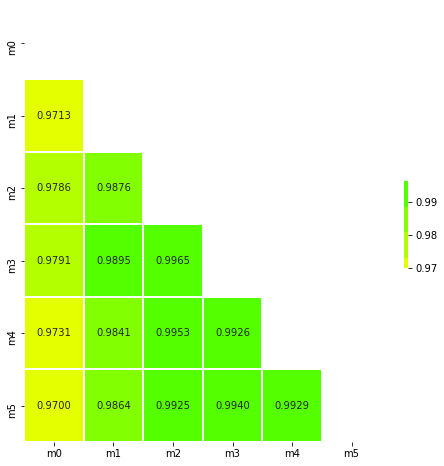

In [33]:
corr = concat_sub.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(len(cols)+2, len(cols)+2))

_ = sns.heatmap(corr,mask=mask,cmap='prism',center=0, linewidths=1,
                annot=True,fmt='.4f', cbar_kws={"shrink":.2})

In [34]:
mean_corr = corr.mean()
mean_corr = mean_corr.sort_values(ascending=True)
mean_corr

m0    0.978687
m1    0.986487
m5    0.989304
m4    0.989674
m2    0.991763
m3    0.991968
dtype: float64

In [35]:
m_gmean = 0
for n in mean_corr.index:
    m_gmean += np.log(concat_sub[n])
m_gmean = np.exp(m_gmean/len(mean_corr))

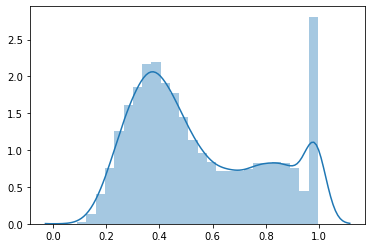

In [36]:
sns.distplot(m_gmean.values)

In [37]:
sub['voted'] = m_gmean.values
sub.head()

,voted
index,
0,0.593534
1,0.931930
2,0.584441
3,0.180959
4,0.737928


In [38]:
# sub.to_csv('./sub/gmean.csv')